In [120]:
!pip install tensorboardX

In [121]:
import collections
import gymnasium as gym
from tensorboardX import SummaryWriter

In [127]:
ENV_NAME = "FrozenLake-v1"
GAMMA = 0.9
NUM_RANDOM_STEPS = 100
TEST_EPISODES = 20

In [128]:
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state,_= self.env.reset()
        # defaultdict initializes with default values
        self.rewards = collections.defaultdict(float)
        # Counter sub class creates a dict with counters of iterables
        self.transits = collections.defaultdict(collections.Counter)
        # Values for each state are contained in this dict
        self.values = collections.defaultdict(float)

    # play random steps to populate the reward and transition matrix dictionaries
    def play_n_random_steps(self, count):
        for _ in range(count):
            # sample an action from action space
            action = self.env.action_space.sample()
            new_state, reward, is_done, _,_ = self.env.step(action)
            # update the reward
            self.rewards[(self.state, action, new_state)] = reward
            # increase the counter of action,state pair in transition matrix
            self.transits[(self.state, action)][new_state] += 1
            self.state = self.env.reset()[0] if is_done else new_state

    def calc_action_value(self, state, action):
        # computation of transition probabilities from the individual counters
        target_counts = self.transits[(state, action)]
        total = sum(target_counts.values())
        action_value = 0.0
        for tgt_state, count in target_counts.items():
            reward = self.rewards[(state, action, tgt_state)]
            # Bellman value iteration update
            action_value += (count / total) * (reward + GAMMA * self.values[tgt_state])
        return action_value

    def select_action(self, state):
        # Select the action which produces maximum value for a given state
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.calc_action_value(state, action)
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action

    def play_episode(self, env):
        total_reward = 0.0
        state, _ = env.reset()
        #play an episode till it is done i.e reached goal or fell inside hole
        while True:
            action = self.select_action(state)
            new_state, reward, is_done, _,_ = env.step(action)
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward
    # update the values for each state with max of the possible state values
    def value_iteration(self):
        for state in range(self.env.observation_space.n):
            state_values = [self.calc_action_value(state, action)
                            for action in range(self.env.action_space.n)]
            self.values[state] = max(state_values)


In [129]:
    test_env = gym.make(ENV_NAME)
    agent = Agent()
    rewards = []

    iter_no = 0
    best_reward = 0.0
    while True:
        iter_no += 1
        agent.play_n_random_steps(NUM_RANDOM_STEPS)
        agent.value_iteration()

        reward = 0.0
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        reward /= TEST_EPISODES
        rewards.append(reward)
        if reward > best_reward:
            print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
            best_reward = reward
        if reward > 0.80:
            print("Solved in %d iterations!" % iter_no)
            break


Best reward updated 0.000 -> 0.400
Best reward updated 0.400 -> 0.600
Best reward updated 0.600 -> 0.800
Best reward updated 0.800 -> 0.900
Solved in 14 iterations!


In [130]:
best_reward

0.9

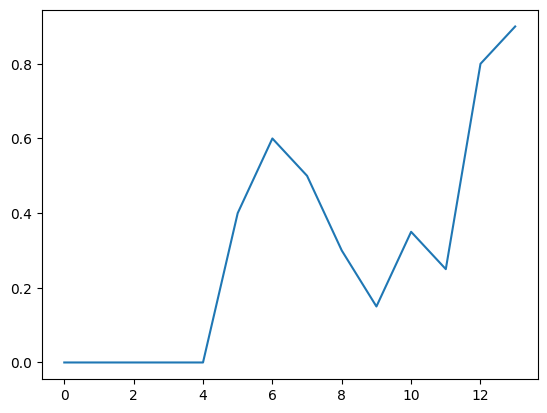

In [131]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

We have solved the problem using the value table approach. We will now solve the problem using Q-table approach. Fundamentally both are same with similar computational complexity, but the Q-table approach is more intuitive. Instead of just storing the values for each state in value table, we now store values for state,action pair and use these to drive the agent to get maximum rewards

In [132]:
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state,_= self.env.reset()
        # defaultdict initializes with default values
        self.rewards = collections.defaultdict(float)
        # Counter sub class creates a dict with counters of iterables
        self.transits = collections.defaultdict(collections.Counter)
        # Values for each state are contained in this dict
        self.values = collections.defaultdict(float)

    # play random steps to populate the reward and transition matrix dictionaries
    def play_n_random_steps(self, count):
        for _ in range(count):
            # sample an action from action space
            action = self.env.action_space.sample()
            new_state, reward, is_done, _,_ = self.env.step(action)
            # update the reward
            self.rewards[(self.state, action, new_state)] = reward
            # increase the counter of action,state pair in transition matrix
            self.transits[(self.state, action)][new_state] += 1
            self.state = self.env.reset()[0] if is_done else new_state

    def select_action(self, state):
        # Select the action which produces maximum value for a given state
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state,action)]
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action

    def play_episode(self, env):
        total_reward = 0.0
        state, _ = env.reset()
        #play an episode till it is done i.e reached goal or fell inside hole
        while True:
            action = self.select_action(state)
            new_state, reward, is_done, _,_ = env.step(action)
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward

    # update the values for each (state, action)
    def value_iteration(self):
        for state in range(self.env.observation_space.n):
          for action in range(self.env.action_space.n):
            action_value = 0.0
            target_counts = self.transits[(state, action)]
            total_count = sum(target_counts.values())
            for tgt_state, count in target_counts.items():
              rwd_key = (state, action, tgt_state)
              reward = self.rewards[rwd_key]
              best_action = self.select_action(tgt_state)
              action_value += (count / total_count) * (reward + GAMMA * self.values[(tgt_state, best_action)])
            self.values[(state, action)] = action_value




In [133]:
    test_env = gym.make(ENV_NAME)
    agent = Agent()
    rewards = []

    iter_no = 0
    best_reward = 0.0
    while True:
        iter_no += 1
        agent.play_n_random_steps(NUM_RANDOM_STEPS)
        agent.value_iteration()

        reward = 0.0
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        reward /= TEST_EPISODES
        rewards.append(reward)
        if reward > best_reward:
            print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
            best_reward = reward
        if reward > 0.80:
            print("Solved in %d iterations!" % iter_no)
            break

Best reward updated 0.000 -> 0.650
Best reward updated 0.650 -> 0.900
Solved in 16 iterations!
